<a href="https://colab.research.google.com/github/Savith-02/notebooks/blob/main/lastModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Configuration
SEED = 42
EPOCHS = 20
BATCH_SIZE = 32
SEQ_LENGTH = 60
PRED_LENGTH = 8
TRAINING_DATE_END = '8-12-31'
SUBMISSION_DATE_START = '9-1-1'
SUBMISSION_DATE_END = '9-5-31'

# Features config
OUTPUT_FEATURES = ['Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed', 'Wind_Direction']

def set_seeds(seed_value):
    """Set seeds for reproducibility"""
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

def setup_gpu():
    """Configure GPU if available"""
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        print(f"Found {len(physical_devices)} GPU(s)")
        try:
            for device in physical_devices:
                tf.config.experimental.set_memory_growth(device, True)
            tf.keras.mixed_precision.set_global_policy('mixed_float16')
            return True
        except Exception as e:
            print(f"Error configuring GPU: {str(e)}")
            return False
    else:
        print("No GPU found. Using CPU.")
        return False

def smape(y_true, y_pred):
    """Calculate Symmetric Mean Absolute Percentage Error"""
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / np.maximum(denominator, 1e-8)
    return 100.0 * np.mean(diff)

def add_kingdom_id(df):
    """Add kingdom_ID column to the DataFrame"""
    unique_kingdoms = df['kingdom'].unique()
    kingdom_to_id = {kingdom: i + 1 for i, kingdom in enumerate(unique_kingdoms)}
    df['kingdom_ID'] = df['kingdom'].map(kingdom_to_id)
    return df

def build_model(input_shape, output_timesteps, num_features, lr=0.001):
    """Build LSTM model for forecasting"""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.LSTM(
            160,
            return_sequences=False,
            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
            kernel_regularizer=tf.keras.regularizers.l2(1e-6)
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.RepeatVector(output_timesteps),
        tf.keras.layers.LSTM(
            160,
            return_sequences=True,
            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
            kernel_regularizer=tf.keras.regularizers.l2(1e-6)
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(
            80,
            return_sequences=True,
            kernel_initializer=tf.keras.initializers.GlorotUniform(seed=SEED),
            recurrent_dropout=0.1
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_features))
    ])

    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=lr * 1.5,
        decay_steps=1500,
        alpha=0.05
    )

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=lr_schedule,
        clipnorm=1.0
    )

    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error'
    )

    return model

def date_to_days(date_tuple):
    """Convert date tuple to days"""
    year, month, day = date_tuple
    days_in_month = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    days = day
    for m in range(1, month):
        days += days_in_month[m]
    days += 365 * year

    return days

def post_process_predictions(predictions):
    """Post-process predictions to fix issues"""
    # Fix negative values for Rain_Amount
    if 'Rain_Amount' in predictions.columns:
        predictions['Rain_Amount'] = predictions['Rain_Amount'].apply(lambda x: max(0, x))

    # Sort predictions
    results = predictions.sort_values(by=['Month', 'Day', 'kingdom'])

    return results

def train_model(X, y, scalers, epochs=55, batch_size=32, is_using_gpu=False, validate=False, kingdom_name=None):
    """Train the forecasting model"""
    if X.size == 0 or y.size == 0:
        print("Error: No training sequences could be created.")
        return None, None

    input_shape = (X.shape[1], X.shape[2])
    model = build_model(input_shape, y.shape[1], y.shape[2])
    model.summary()

    # File paths with kingdom name if provided
    model_path = f'kingdom_weather_model_{kingdom_name}.keras' if kingdom_name else 'kingdom_weather_model.keras'
    best_model_path = f'kingdom_weather_model_{kingdom_name}_best.keras' if kingdom_name else 'kingdom_weather_model_best.keras'
    plot_path = f'training_history_{kingdom_name}.png' if kingdom_name else 'training_history.png'

    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath=model_path,
            save_best_only=False,
            verbose=1
        )
    ]

    batch_size = batch_size * 2 if is_using_gpu else batch_size

    if validate:
        # Split data into training and validation sets (80:20) without shuffling
        n_samples = len(X)

        # Calculate split point (80% training, 20% validation)
        val_size = int(0.2 * n_samples)
        train_size = n_samples - val_size

        # Split without shuffling - use the last 20% for validation
        X_train, X_val = X[:train_size], X[train_size:]
        y_train, y_val = y[:train_size], y[train_size:]

        print(f"Training with {len(X_train)} sequences, validating with {len(X_val)} sequences")

        # Update callbacks to save best model based on validation loss
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath=best_model_path,
                save_best_only=True,
                monitor='val_loss',
                mode='min',
                verbose=1
            ),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=model_path,
                save_best_only=False,
                verbose=1
            )
        ]

        # Train with validation
        history = model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_val, y_val),
            callbacks=callbacks,
            verbose=1
        )

        # Plot training history
        try:
            import matplotlib.pyplot as plt
            plt.figure(figsize=(8, 4))
            plt.plot(history.history['loss'], label='Training Loss')
            plt.plot(history.history['val_loss'], label='Validation Loss')

            # Add kingdom name to title if provided
            if kingdom_name:
                plt.title(f'Model Loss - {kingdom_name}')
            else:
                plt.title('Model Loss')

            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend()

            # Save the plot
            plt.savefig(plot_path)

            # Show the plot
            plt.show()

            # Close to prevent memory issues
            plt.close()

            print(f"Training history plot saved to {plot_path}")
        except Exception as e:
            print(f"Could not create plot: {str(e)}")

        # Try to load the best model
        try:
            model = tf.keras.models.load_model(best_model_path)
            print("Loaded best model based on validation loss")
        except:
            print("Could not load best model, using final model instead")
    else:
        # Original training without validation
        history = model.fit(
            X, y,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

    model.save(model_path)
    print(f"Model saved to {model_path}")

    return model, history

def prepare_data(df, training_date_end):
    """Prepare data for training"""
    end_year, end_month, end_day = map(int, training_date_end.split('-'))
    df = df.dropna(subset=['kingdom'])

    date_mask = (
        (df['Year'] < end_year) |
        ((df['Year'] == end_year) & (df['Month'] < end_month)) |
        ((df['Year'] == end_year) & (df['Month'] == end_month) & (df['Day'] <= end_day))
    )
    df = df[date_mask]

    # Get list of kingdoms
    kingdoms = sorted(df['kingdom'].unique())[:NUM_KINGDOMS]
    df = df[df['kingdom'].isin(kingdoms)]

    kingdom_info = {}
    for kingdom in kingdoms:
        k_data = df[df['kingdom'] == kingdom].iloc[0]
        kingdom_info[kingdom] = {
            'id': int(k_data['kingdom_ID'])
        }

    return df, kingdoms, kingdom_info

def scale_features(data, features):
    """Scale features using MinMaxScaler"""
    scalers = {}
    scaled_data = data.copy()
    non_scaled_features = ['Year', 'Month', 'Day', 'kingdom_ID']

    for feature in features:
        if feature in non_scaled_features:
            scalers[feature] = None
            continue

        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data[feature] = scaler.fit_transform(data[feature].values.reshape(-1, 1))
        scalers[feature] = scaler

    return scaled_data, scalers

def create_sequences(data, input_features, output_features, seq_length=60, pred_length=8):
    """Create sequences for training"""
    sequences = []
    targets = []

    for kingdom_id in data['kingdom_ID'].unique():
        kingdom_data = data[data['kingdom_ID'] == kingdom_id].copy()
        kingdom_data.loc[:, 'date_tuple'] = list(zip(kingdom_data['Year'], kingdom_data['Month'], kingdom_data['Day']))
        unique_dates = sorted(kingdom_data['date_tuple'].unique())

        if len(unique_dates) < seq_length + pred_length:
            continue

        date_to_row = {}
        for _, row in kingdom_data.iterrows():
            date_tuple = (row['Year'], row['Month'], row['Day'])
            date_to_row[date_tuple] = row

        for i in range(0, len(unique_dates) - seq_length - pred_length + 1, 8):
            seq_dates = unique_dates[i:i+seq_length]
            target_dates = unique_dates[i+seq_length:i+seq_length+pred_length]

            seq_data = []
            target_data = []

            all_dates_found = True
            for date in seq_dates:
                if date in date_to_row:
                    seq_data.append(date_to_row[date][input_features].values)
                else:
                    all_dates_found = False
                    break

            if not all_dates_found:
                continue

            all_dates_found = True
            for date in target_dates:
                if date in date_to_row:
                    target_data.append(date_to_row[date][output_features].values)
                else:
                    all_dates_found = False
                    break

            if all_dates_found and len(seq_data) == seq_length and len(target_data) == pred_length:
                sequences.append(np.array(seq_data))
                targets.append(np.array(target_data))

    sequences_array = np.array(sequences, dtype=np.float32)
    targets_array = np.array(targets, dtype=np.float32)

    print(f"Created {len(sequences)} sequence-target pairs")
    return sequences_array, targets_array


def add_engineered_features(df):
    """Add engineered features to the dataset"""
    df = df.sort_values(by=['kingdom_ID', 'Year', 'Month', 'Day']).copy()
    grouped = df.groupby('kingdom_ID')

    base_features = ['Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed', 'Wind_Direction']
    non_radiation_features = [f for f in base_features if f != 'Radiation']

    # Lag features
    for lag in [1, 3, 365]:
        for feature in base_features:
            df[f'{feature}_lag_{lag}'] = grouped[feature].transform(lambda x: x.shift(lag))

    # Half-year lag
    for feature in non_radiation_features:
        df[f'{feature}_lag_182'] = grouped[feature].transform(lambda x: x.shift(182))

    # Rolling statistics
    for feature in base_features:
        df[f'{feature}_rollmean_3'] = grouped[feature].transform(lambda x: x.rolling(3, min_periods=1).mean())
        df[f'{feature}_rollmin_3'] = grouped[feature].transform(lambda x: x.rolling(3, min_periods=1).min())
        df[f'{feature}_rollmax_3'] = grouped[feature].transform(lambda x: x.rolling(3, min_periods=1).max())

    # Use rolling average instead of LOWESS
    for feature in base_features:
        df[f'{feature}_lowess_5'] = grouped[feature].transform(lambda x: x.rolling(7, min_periods=1).mean())

    # Cyclical features
    df['month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
    df['day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
    df['wind_dir_sin'] = np.sin(np.radians(df['Wind_Direction']))
    df['wind_dir_cos'] = np.cos(np.radians(df['Wind_Direction']))

    # Find and remove the first 365 records for each kingdom
    filtered_df = pd.DataFrame()
    for kingdom in df['kingdom_ID'].unique():
        kingdom_data = df[df['kingdom_ID'] == kingdom]

        # Sort by date to ensure we're removing the earliest records
        kingdom_data = kingdom_data.sort_values(by=['Year', 'Month', 'Day'])

        # Remove the first 365 records if the kingdom has that many
        if len(kingdom_data) > 365:
            kingdom_data_filtered = kingdom_data.iloc[365:]
        else:
            # If less than 365 records exist, keep all records
            print(f"Warning: Kingdom {kingdom} has fewer than 365 records ({len(kingdom_data)})")
            kingdom_data_filtered = kingdom_data

        filtered_df = pd.concat([filtered_df, kingdom_data_filtered])

    return filtered_df

def calculate_past_date(year, month, day, days_back):
    """Calculate a date in the past from a given date"""
    date = pd.Timestamp(year=year, month=month, day=day)
    past_date = date - pd.Timedelta(days=days_back)
    return past_date.year, past_date.month, past_date.day

def add_engineered_features_for_prediction(row_dict, previous_rows=None, full_dataset=None, kingdom=None):
    """Add engineered features to a single prediction row without creating NaN values"""
    result = row_dict.copy()

    # Base features
    base_features = ['Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed', 'Wind_Direction']
    non_radiation_features = [f for f in base_features if f != 'Radiation']

    # For long-term lags, try to get from full dataset if available
    if full_dataset is not None and kingdom is not None:
        current_year, current_month, current_day = row_dict['Year'], row_dict['Month'], row_dict['Day']

        # Handle 365-day lag features from full dataset
        for lag in [365, 182]:
            # Calculate the date for lag
            lag_year, lag_month, lag_day = subtract_days(current_year, current_month, current_day, lag)


            # Find data for that date in the full dataset
            lag_data = full_dataset[
                (full_dataset['kingdom'] == kingdom) &
                (full_dataset['Year'] == lag_year) &
                (full_dataset['Month'] == lag_month) &
                (full_dataset['Day'] == lag_day)
            ]

            if not lag_data.empty:
                # Found historical data for this lag
                features_to_lag = base_features if lag == 365 else non_radiation_features
                for feature in features_to_lag:
                    result[f'{feature}_lag_{lag}'] = lag_data[feature].values[0]
            else:
                # Couldn't find exact date in history, use fallback
                features_to_lag = base_features if lag == 365 else non_radiation_features
                for feature in features_to_lag:
                    # Fallback to using current value
                    result[f'{feature}_lag_{lag}'] = result[feature]

    # Get values from previous rows for shorter lags and other features
    if previous_rows is not None and len(previous_rows) > 0:
        # Short-term lag features (1-day, 3-day)
        for lag in [1, 3]:
            for feature in base_features:
                lag_col = f'{feature}_lag_{lag}'
                if len(previous_rows) >= lag:
                    result[lag_col] = previous_rows.iloc[-lag][feature]
                else:
                    # If we don't have enough history, use the earliest available value
                    result[lag_col] = previous_rows.iloc[0][feature]

        # Add long-term lags if not already set from full dataset
        if full_dataset is None or kingdom is None:
            # 365-day lag fallbacks
            for feature in base_features:
                lag_col = f'{feature}_lag_365'
                if lag_col not in result:
                    result[lag_col] = result[feature]

            # 182-day lag fallbacks
            for feature in non_radiation_features:
                lag_col = f'{feature}_lag_182'
                if lag_col not in result:
                    result[lag_col] = result[feature]

        # Rolling statistics - use the most recent values if we don't have enough data
        for feature in base_features:
            if len(previous_rows) >= 3:
                recent_vals = previous_rows.iloc[-3:][feature].values
                result[f'{feature}_rollmean_3'] = np.mean(recent_vals)
                result[f'{feature}_rollmin_3'] = np.min(recent_vals)
                result[f'{feature}_rollmax_3'] = np.max(recent_vals)
            else:
                # Not enough data for rolling, use the current value
                result[f'{feature}_rollmean_3'] = result[feature]
                result[f'{feature}_rollmin_3'] = result[feature]
                result[f'{feature}_rollmax_3'] = result[feature]

            # Use rolling average instead of LOWESS
            if len(previous_rows) >= 7:
                recent_vals = previous_rows.iloc[-7:][feature].values
                result[f'{feature}_lowess_5'] = np.mean(recent_vals)
            else:
                result[f'{feature}_lowess_5'] = result[feature]
    else:
        # No previous data - use the current values for all lag and rolling features
        # Short-term lags
        for lag in [1, 3]:
            for feature in base_features:
                lag_col = f'{feature}_lag_{lag}'
                if lag_col not in result:
                    result[lag_col] = result[feature]

        # Long-term lags if not already set
        for feature in base_features:
            lag_col = f'{feature}_lag_365'
            if lag_col not in result:
                result[lag_col] = result[feature]

        for feature in non_radiation_features:
            lag_col = f'{feature}_lag_182'
            if lag_col not in result:
                result[lag_col] = result[feature]

        # For rolling features, use the current value
        for feature in base_features:
            result[f'{feature}_rollmean_3'] = result[feature]
            result[f'{feature}_rollmin_3'] = result[feature]
            result[f'{feature}_rollmax_3'] = result[feature]
            result[f'{feature}_lowess_5'] = result[feature]

    # Cyclical features - these can always be calculated exactly
    month = result['Month']
    day = result['Day']
    wind_dir = result['Wind_Direction']

    result['month_sin'] = np.sin(2 * np.pi * month / 12)
    result['month_cos'] = np.cos(2 * np.pi * month / 12)
    result['day_sin'] = np.sin(2 * np.pi * day / 31)
    result['day_cos'] = np.cos(2 * np.pi * day / 31)
    result['wind_dir_sin'] = np.sin(np.radians(wind_dir))
    result['wind_dir_cos'] = np.cos(np.radians(wind_dir))

    return result

def recursive_forecast(model, data, kingdom, start_date, num_predictions, input_features, output_features, seq_length=60):
    """Perform recursive forecasting for a single kingdom"""
    print(f"Starting recursive forecast for {kingdom}, need {num_predictions} days")

    # Filter the data
    kingdom_data = data[data['kingdom'] == kingdom].copy()
    kingdom_data = kingdom_data.sort_values(by=['Year', 'Month', 'Day'])

    print(f"Found {len(kingdom_data)} records for {kingdom}")

    if len(kingdom_data) == 0:
        return pd.DataFrame()

    # Find start date
    start_year, start_month, start_day = start_date
    filtered_data = kingdom_data[
        (kingdom_data['Year'] == start_year) &
        (kingdom_data['Month'] == start_month) &
        (kingdom_data['Day'] == start_day)
    ]

    if len(filtered_data) == 0:
        # Try to find closest date
        last_data = kingdom_data.tail(1)
        if not last_data.empty:
            filtered_data = last_data
        else:
            return pd.DataFrame()

    # Get initial data
    start_idx = filtered_data.index[0]
    all_indices = kingdom_data.index.tolist()
    position = all_indices.index(start_idx)

    if position < seq_length - 1:
        initial_data = kingdom_data.iloc[:position+1]
    else:
        initial_data = kingdom_data.iloc[position-seq_length+1:position+1]

    # Get all predictions in a single batch
    results = []
    batch_size = 8  # Predict 8 days at a time

    # Use just the most recent window for each prediction
    while len(results) < num_predictions:
        # Get latest sequence
        if len(initial_data) > seq_length:
            latest_data = initial_data.tail(seq_length)
        else:
            latest_data = initial_data

        # Build input sequence
        X_seq = np.array([latest_data[input_features].values])

        # Make prediction
        y_pred = model.predict(X_seq, verbose=0)

        # Get prediction dates
        last_date = (
            initial_data.iloc[-1]['Year'],
            initial_data.iloc[-1]['Month'],
            initial_data.iloc[-1]['Day']
        )

        # Calculate next dates
        pred_dates = []
        current_year, current_month, current_day = last_date

        for _ in range(min(batch_size, num_predictions - len(results))):
            current_day += 1
            days_in_month = pd.Timestamp(
                year=int(current_year),
                month=int(current_month),
                day=1
            ).days_in_month

            if current_day > days_in_month:
                current_day = 1
                current_month += 1
                if current_month > 12:
                    current_month = 1
                    current_year += 1

            pred_dates.append((current_year, current_month, current_day))

        # Create predictions
        new_rows = []
        complete_rows = []

        # Inside recursive_forecast function, modify this section:
        for i in range(min(batch_size, num_predictions - len(results))):
            year, month, day = pred_dates[i]

            # Create basic row
            new_row = {
                'kingdom': kingdom,
                'Year': int(year),
                'Month': int(month),
                'Day': int(day)
            }

            # Add predicted values
            for j, feature in enumerate(output_features):
                new_row[feature] = float(y_pred[0, i, j])

            # Create a complete row with all engineered features
            # Pass the full dataset and kingdom to properly calculate lag features
            if i == 0:
                complete_row = add_engineered_features_for_prediction(
                    new_row, initial_data, data, kingdom)
            else:
                prev_data = pd.DataFrame(complete_rows + [new_row])
                complete_row = add_engineered_features_for_prediction(
                    new_row, prev_data, data, kingdom)

            complete_rows.append(complete_row)
            results.append(complete_row)

        # End predictions when we have enough
        if len(results) >= num_predictions:
            break

        # Create complete DataFrame with all engineered features for new predictions
        new_complete_df = pd.DataFrame(complete_rows)

        # Update the initial window with new data
        if not new_complete_df.empty:
            if len(initial_data) > len(new_complete_df):
                initial_data = initial_data.iloc[len(new_complete_df):]
                initial_data = pd.concat([initial_data, new_complete_df], ignore_index=True)
            else:
                initial_data = new_complete_df

    # Create result dataframe with all predictions
    results_df = pd.DataFrame(results[:num_predictions])

    print(f"Generated {len(results_df)} predictions for {kingdom}")
    return results_df

def generate_predictions_per_kingdom(model, data, kingdoms, start_date, end_date, training_end, submission_mode=True):
    """Generate predictions for each kingdom separately"""
    print(f"Starting predictions for {len(kingdoms)} kingdoms")

    # Calculate number of days to predict
    start_days = date_to_days(start_date)
    end_days = date_to_days(end_date)
    num_days = end_days - start_days + 1

    print(f"Predicting {num_days} days from {start_date} to {end_date}")

    # Define input features - all the columns needed for prediction
    input_features = [
        'Year',
        'Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed', 'Wind_Direction',
        'Avg_Temperature_lag_1', 'Avg_Temperature_lag_3', 'Avg_Temperature_lag_365',
        'Radiation_lag_1', 'Radiation_lag_3', 'Radiation_lag_365',
        'Rain_Amount_lag_1', 'Rain_Amount_lag_3', 'Rain_Amount_lag_365',
        'Wind_Speed_lag_1', 'Wind_Speed_lag_3', 'Wind_Speed_lag_365',
        'Wind_Direction_lag_1', 'Wind_Direction_lag_3', 'Wind_Direction_lag_365',
        'Avg_Temperature_lag_182', 'Rain_Amount_lag_182',
        'Wind_Speed_lag_182', 'Wind_Direction_lag_182',
        'Avg_Temperature_rollmean_3', 'Avg_Temperature_rollmin_3', 'Avg_Temperature_rollmax_3',
        'Radiation_rollmean_3', 'Radiation_rollmin_3', 'Radiation_rollmax_3',
        'Rain_Amount_rollmean_3', 'Rain_Amount_rollmin_3', 'Rain_Amount_rollmax_3',
        'Wind_Speed_rollmean_3', 'Wind_Speed_rollmin_3', 'Wind_Speed_rollmax_3',
        'Wind_Direction_rollmean_3', 'Wind_Direction_rollmin_3', 'Wind_Direction_rollmax_3',
        'Avg_Temperature_lowess_5', 'Radiation_lowess_5',
        'Rain_Amount_lowess_5', 'Wind_Speed_lowess_5', 'Wind_Direction_lowess_5',
        'month_sin', 'month_cos', 'day_sin', 'day_cos',
        'wind_dir_sin', 'wind_dir_cos'
    ]

    all_kingdom_predictions = {}
    combined_predictions = []

    for kingdom in kingdoms:
        print(f"\nProcessing kingdom: {kingdom}")

        # Determine last date
        if submission_mode:
            last_date = training_end
        else:
            year, month, day = start_date
            day -= 1
            if day == 0:
                month -= 1
                if month == 0:
                    month = 12
                    year -= 1
                days_in_month = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
                day = days_in_month[month]

            last_date = (year, month, day)

        print(f"Using last date for kingdom {kingdom}: {last_date}")

        # Generate predictions
        kingdom_predictions = recursive_forecast(
            model, data, kingdom, last_date, num_days,
            input_features, OUTPUT_FEATURES
        )

        print(f"Received {len(kingdom_predictions)} predictions for {kingdom}")

        if not kingdom_predictions.empty:
            # Save individual kingdom predictions
            kingdom_file = f"predictions_{kingdom.lower().replace(' ', '_')}.csv"
            kingdom_predictions.to_csv(kingdom_file, index=False)
            print(f"Saved predictions to {kingdom_file}")

            # Store in dictionary and add to combined list
            all_kingdom_predictions[kingdom] = kingdom_predictions
            combined_predictions.append(kingdom_predictions)

    # Combine all kingdom predictions
    if combined_predictions:
        final_predictions = pd.concat(combined_predictions, ignore_index=True)
        print(f"Combined predictions shape: {final_predictions.shape}")

        if len(final_predictions) > 0:
            # Post-process predictions
            final_predictions = post_process_predictions(final_predictions)

            output_path = (
                "kingdom_weather_predictions_submission.csv"
                if submission_mode else
                "kingdom_weather_predictions_testing.csv"
            )
            final_predictions.to_csv(output_path, index=False)

            # Save final results
            final_predictions.to_csv('results_good_updated.csv', index=False)

            return final_predictions, all_kingdom_predictions
    else:
        print("No predictions were generated!")

    return pd.DataFrame(), {}

def subtract_days(year, month, day, days_to_subtract):
    """Custom function to subtract days from a date, handling edge cases with very early years"""
    # Define days in each month (ignoring leap years for simplicity)
    days_in_month = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

    # Convert date to total days from year 0
    total_days = day
    for m in range(1, month):
        total_days += days_in_month[m]
    total_days += 365 * year

    # Subtract days
    result_days = total_days - days_to_subtract

    # Convert back to y/m/d
    result_year = result_days // 365
    remaining_days = result_days % 365

    result_month = 1
    while remaining_days > days_in_month[result_month]:
        remaining_days -= days_in_month[result_month]
        result_month += 1
        if result_month > 12:
            break

    result_day = remaining_days

    # Handle edge case where result_day is 0
    if result_day == 0:
        result_month -= 1
        if result_month == 0:
            result_month = 12
            result_year -= 1
        result_day = days_in_month[result_month]

    return max(1, result_year), result_month, result_day  # Ensure year is at least 1


In [34]:
NUM_KINGDOMS = 30

In [36]:
# Initialize environment
set_seeds(SEED)
is_using_gpu = setup_gpu()

# Load data
print("Loading data...")
url = 'https://drive.google.com/uc?id=1DsKaiLMxsT-VHKwqm4vvtANCIjadi1-r'
df = pd.read_csv(url)
df = add_kingdom_id(df)

# Add engineering features
print("Adding engineered features...")
engineered_data = add_engineered_features(df)

# Prepare data
print("Preparing data...")
data, kingdoms, kingdom_info = prepare_data(engineered_data, TRAINING_DATE_END)

# Define input features - these must match what's in the forecast function
input_features = [
    'Year',
    'Avg_Temperature', 'Radiation', 'Rain_Amount', 'Wind_Speed', 'Wind_Direction',
    'Avg_Temperature_lag_1', 'Avg_Temperature_lag_3', 'Avg_Temperature_lag_365',
    'Radiation_lag_1', 'Radiation_lag_3', 'Radiation_lag_365',
    'Rain_Amount_lag_1', 'Rain_Amount_lag_3', 'Rain_Amount_lag_365',
    'Wind_Speed_lag_1', 'Wind_Speed_lag_3', 'Wind_Speed_lag_365',
    'Wind_Direction_lag_1', 'Wind_Direction_lag_3', 'Wind_Direction_lag_365',
    'Avg_Temperature_lag_182', 'Rain_Amount_lag_182',
    'Wind_Speed_lag_182', 'Wind_Direction_lag_182',
    'Avg_Temperature_rollmean_3', 'Avg_Temperature_rollmin_3', 'Avg_Temperature_rollmax_3',
    'Radiation_rollmean_3', 'Radiation_rollmin_3', 'Radiation_rollmax_3',
    'Rain_Amount_rollmean_3', 'Rain_Amount_rollmin_3', 'Rain_Amount_rollmax_3',
    'Wind_Speed_rollmean_3', 'Wind_Speed_rollmin_3', 'Wind_Speed_rollmax_3',
    'Wind_Direction_rollmean_3', 'Wind_Direction_rollmin_3', 'Wind_Direction_rollmax_3',
    'Avg_Temperature_lowess_5', 'Radiation_lowess_5',
    'Rain_Amount_lowess_5', 'Wind_Speed_lowess_5', 'Wind_Direction_lowess_5',
    'month_sin', 'month_cos', 'day_sin', 'day_cos',
    'wind_dir_sin', 'wind_dir_cos'
]

# Filter out any input features not in data
available_input_features = [f for f in input_features if f in data.columns]
print(f"Using {len(available_input_features)} of {len(input_features)} input features")

No GPU found. Using CPU.
Loading data...
Adding engineered features...
Preparing data...
Using 51 of 51 input features


In [38]:
EPOCHS = 30
submission_mode = True


=== Processing kingdom: Arcadia ===
Scaling features for Arcadia...
Creating training sequences for Arcadia...
Created 300 sequence-target pairs
Training new model for Arcadia...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 160)                 │         135,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 160)                 │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 8, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8, 160)              │         205,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 160)              │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 8, 80)               │          77,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 80)               │             320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 80)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 8, 5)                │             405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 420,245 (1.60 MB)

 Trainable params: 419,445 (1.60 MB)

 Non-trainable params: 800 (3.12 KB)

Training with 240 sequences, validating with 60 sequences
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 2.0321
Epoch 1: val_loss improved from inf to 0.20210, saving model to kingdom_weather_model_arcadia_best.keras

Epoch 1: saving model to kingdom_weather_model_arcadia.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 448ms/step - loss: 1.9903 - val_loss: 0.2021
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.9900
Epoch 2: val_loss improved from 0.20210 to 0.15569, saving model to kingdom_weather_model_arcadia_best.keras

Epoch 2: saving model to kingdom_weather_model_arcadia.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.9850 - val_loss: 0.1557
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.7305
Epoch 3: val_loss improved from 0.15569 to 0.12286, saving model to kingdom_weather_model_arcadia_best.keras

Epoch 3: saving model to kingdom_weather_model_arcadia.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.7272 - val_loss: 0.1229
Epoch 4/30
8/8 ━━━

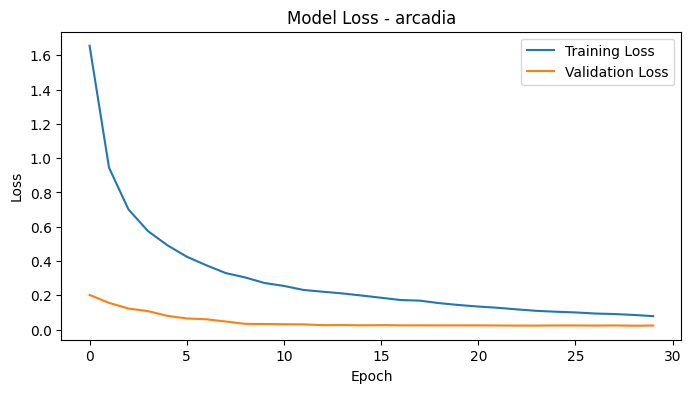

Training history plot saved to training_history_arcadia.png
Loaded best model based on validation loss
Model saved to kingdom_weather_model_arcadia.keras
Generating predictions for Arcadia from (9, 1, 1) to (9, 5, 31)...
Using last date for Arcadia: (8, 12, 31)
Starting recursive forecast for Arcadia, need 151 days
Found 2467 records for Arcadia
Generated 151 predictions for Arcadia
Received 151 predictions for Arcadia
Saved predictions to predictions_arcadia.csv

=== Processing kingdom: Atlantis ===
Scaling features for Atlantis...
Creating training sequences for Atlantis...
Created 300 sequence-target pairs
Training new model for Atlantis...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 160)                 │         135,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 160)                 │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 8, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8, 160)              │         205,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 160)              │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 8, 80)               │          77,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 80)               │             320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 80)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 8, 5)                │             405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 420,245 (1.60 MB)

 Trainable params: 419,445 (1.60 MB)

 Non-trainable params: 800 (3.12 KB)

Training with 240 sequences, validating with 60 sequences
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 2.3262
Epoch 1: val_loss improved from inf to 0.22753, saving model to kingdom_weather_model_atlantis_best.keras

Epoch 1: saving model to kingdom_weather_model_atlantis.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 401ms/step - loss: 2.2676 - val_loss: 0.2275
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - loss: 0.9886
Epoch 2: val_loss did not improve from 0.22753

Epoch 2: saving model to kingdom_weather_model_atlantis.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 0.9826 - val_loss: 0.2288
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.7961
Epoch 3: val_loss improved from 0.22753 to 0.16979, saving model to kingdom_weather_model_atlantis_best.keras

Epoch 3: saving model to kingdom_weather_model_atlantis.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 0.7920 - val_loss: 0.1698
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.6361
Epoch 4: v

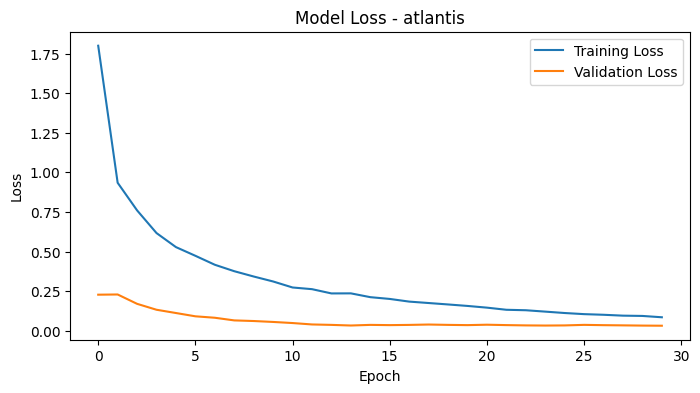

Training history plot saved to training_history_atlantis.png
Loaded best model based on validation loss
Model saved to kingdom_weather_model_atlantis.keras
Generating predictions for Atlantis from (9, 1, 1) to (9, 5, 31)...
Using last date for Atlantis: (8, 12, 31)
Starting recursive forecast for Atlantis, need 151 days
Found 2467 records for Atlantis
Generated 151 predictions for Atlantis
Received 151 predictions for Atlantis
Saved predictions to predictions_atlantis.csv

=== Processing kingdom: Avalon ===
Scaling features for Avalon...
Creating training sequences for Avalon...
Created 300 sequence-target pairs
Training new model for Avalon...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 160)                 │         135,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 160)                 │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 8, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8, 160)              │         205,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 160)              │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 8, 80)               │          77,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 80)               │             320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 80)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 8, 5)                │             405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 420,245 (1.60 MB)

 Trainable params: 419,445 (1.60 MB)

 Non-trainable params: 800 (3.12 KB)

Training with 240 sequences, validating with 60 sequences
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 2.0056
Epoch 1: val_loss improved from inf to 0.23192, saving model to kingdom_weather_model_avalon_best.keras

Epoch 1: saving model to kingdom_weather_model_avalon.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 302ms/step - loss: 1.9640 - val_loss: 0.2319
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 1.0043
Epoch 2: val_loss improved from 0.23192 to 0.15969, saving model to kingdom_weather_model_avalon_best.keras

Epoch 2: saving model to kingdom_weather_model_avalon.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 155ms/step - loss: 0.9977 - val_loss: 0.1597
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.7610
Epoch 3: val_loss improved from 0.15969 to 0.13021, saving model to kingdom_weather_model_avalon_best.keras

Epoch 3: saving model to kingdom_weather_model_avalon.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 0.7572 - val_loss: 0.1302
Epoch 4/30
8/8 ━━━━━━━━━

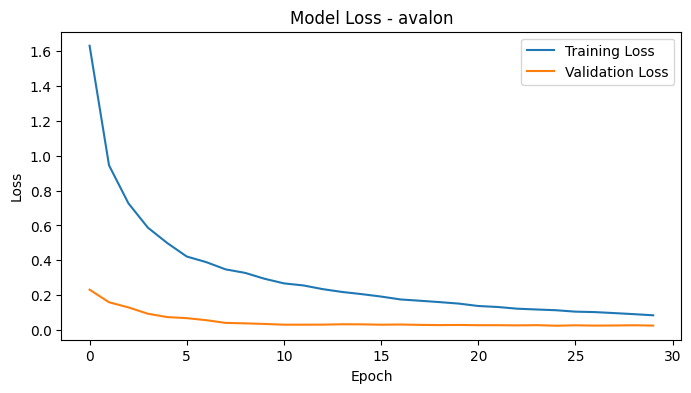

Training history plot saved to training_history_avalon.png
Loaded best model based on validation loss
Model saved to kingdom_weather_model_avalon.keras
Generating predictions for Avalon from (9, 1, 1) to (9, 5, 31)...
Using last date for Avalon: (8, 12, 31)
Starting recursive forecast for Avalon, need 151 days
Found 2467 records for Avalon
Generated 151 predictions for Avalon
Received 151 predictions for Avalon
Saved predictions to predictions_avalon.csv

=== Processing kingdom: Camelot ===
Scaling features for Camelot...
Creating training sequences for Camelot...
Created 300 sequence-target pairs
Training new model for Camelot...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 160)                 │         135,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 160)                 │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 8, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8, 160)              │         205,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 160)              │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 8, 80)               │          77,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 80)               │             320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 80)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 8, 5)                │             405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 420,245 (1.60 MB)

 Trainable params: 419,445 (1.60 MB)

 Non-trainable params: 800 (3.12 KB)

Training with 240 sequences, validating with 60 sequences
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - loss: 2.1137
Epoch 1: val_loss improved from inf to 0.19335, saving model to kingdom_weather_model_camelot_best.keras

Epoch 1: saving model to kingdom_weather_model_camelot.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 365ms/step - loss: 2.0663 - val_loss: 0.1933
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 1.0208
Epoch 2: val_loss improved from 0.19335 to 0.12823, saving model to kingdom_weather_model_camelot_best.keras

Epoch 2: saving model to kingdom_weather_model_camelot.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 151ms/step - loss: 1.0116 - val_loss: 0.1282
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.7511
Epoch 3: val_loss improved from 0.12823 to 0.11303, saving model to kingdom_weather_model_camelot_best.keras

Epoch 3: saving model to kingdom_weather_model_camelot.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - loss: 0.7468 - val_loss: 0.1130
Epoch 4/30
8/8 ━━━

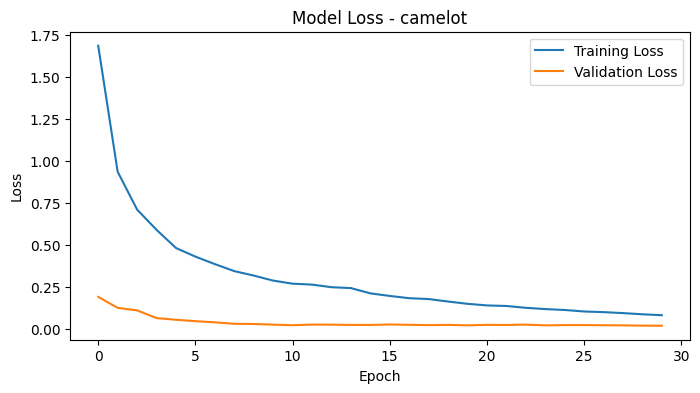

Training history plot saved to training_history_camelot.png
Loaded best model based on validation loss
Model saved to kingdom_weather_model_camelot.keras
Generating predictions for Camelot from (9, 1, 1) to (9, 5, 31)...
Using last date for Camelot: (8, 12, 31)
Starting recursive forecast for Camelot, need 151 days
Found 2467 records for Camelot
Generated 151 predictions for Camelot
Received 151 predictions for Camelot
Saved predictions to predictions_camelot.csv

=== Processing kingdom: Dorne ===
Scaling features for Dorne...
Creating training sequences for Dorne...
Created 300 sequence-target pairs
Training new model for Dorne...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 160)                 │         135,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 160)                 │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 8, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8, 160)              │         205,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 160)              │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 8, 80)               │          77,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 80)               │             320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 80)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 8, 5)                │             405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 420,245 (1.60 MB)

 Trainable params: 419,445 (1.60 MB)

 Non-trainable params: 800 (3.12 KB)

Training with 240 sequences, validating with 60 sequences
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 1.9500
Epoch 1: val_loss improved from inf to 0.22574, saving model to kingdom_weather_model_dorne_best.keras

Epoch 1: saving model to kingdom_weather_model_dorne.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 307ms/step - loss: 1.9137 - val_loss: 0.2257
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.9511
Epoch 2: val_loss improved from 0.22574 to 0.18199, saving model to kingdom_weather_model_dorne_best.keras

Epoch 2: saving model to kingdom_weather_model_dorne.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - loss: 0.9435 - val_loss: 0.1820
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.7054
Epoch 3: val_loss improved from 0.18199 to 0.13687, saving model to kingdom_weather_model_dorne_best.keras

Epoch 3: saving model to kingdom_weather_model_dorne.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - loss: 0.7026 - val_loss: 0.1369
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━

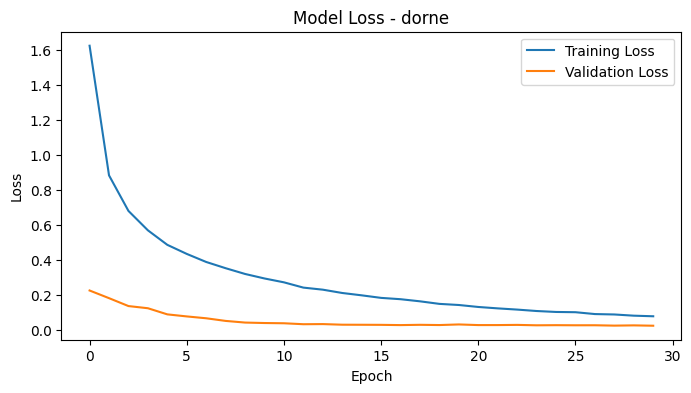

Training history plot saved to training_history_dorne.png
Loaded best model based on validation loss
Model saved to kingdom_weather_model_dorne.keras
Generating predictions for Dorne from (9, 1, 1) to (9, 5, 31)...
Using last date for Dorne: (8, 12, 31)
Starting recursive forecast for Dorne, need 151 days
Found 2467 records for Dorne
Generated 151 predictions for Dorne
Received 151 predictions for Dorne
Saved predictions to predictions_dorne.csv

=== Processing kingdom: Eden ===
Scaling features for Eden...
Creating training sequences for Eden...
Created 300 sequence-target pairs
Training new model for Eden...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 160)                 │         135,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 160)                 │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 8, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8, 160)              │         205,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 160)              │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 8, 80)               │          77,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 80)               │             320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 80)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 8, 5)                │             405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 420,245 (1.60 MB)

 Trainable params: 419,445 (1.60 MB)

 Non-trainable params: 800 (3.12 KB)

Training with 240 sequences, validating with 60 sequences
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 2.0022
Epoch 1: val_loss improved from inf to 0.18698, saving model to kingdom_weather_model_eden_best.keras

Epoch 1: saving model to kingdom_weather_model_eden.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 303ms/step - loss: 1.9675 - val_loss: 0.1870
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 1.0011
Epoch 2: val_loss improved from 0.18698 to 0.11455, saving model to kingdom_weather_model_eden_best.keras

Epoch 2: saving model to kingdom_weather_model_eden.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - loss: 0.9947 - val_loss: 0.1146
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.7190
Epoch 3: val_loss improved from 0.11455 to 0.09443, saving model to kingdom_weather_model_eden_best.keras

Epoch 3: saving model to kingdom_weather_model_eden.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 0.7168 - val_loss: 0.0944
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 

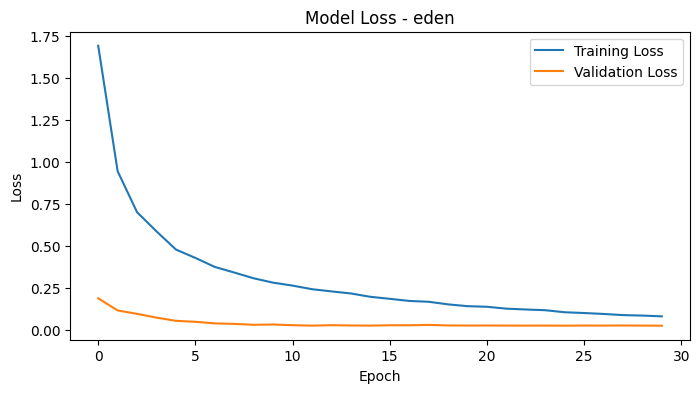

Training history plot saved to training_history_eden.png
Loaded best model based on validation loss
Model saved to kingdom_weather_model_eden.keras
Generating predictions for Eden from (9, 1, 1) to (9, 5, 31)...
Using last date for Eden: (8, 12, 31)
Starting recursive forecast for Eden, need 151 days
Found 2467 records for Eden
Generated 151 predictions for Eden
Received 151 predictions for Eden
Saved predictions to predictions_eden.csv

=== Processing kingdom: El Dorado ===
Scaling features for El Dorado...
Creating training sequences for El Dorado...
Created 300 sequence-target pairs
Training new model for El Dorado...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 160)                 │         135,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 160)                 │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 8, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8, 160)              │         205,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 160)              │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 8, 80)               │          77,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 80)               │             320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 80)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 8, 5)                │             405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 420,245 (1.60 MB)

 Trainable params: 419,445 (1.60 MB)

 Non-trainable params: 800 (3.12 KB)

Training with 240 sequences, validating with 60 sequences
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 2.2392
Epoch 1: val_loss improved from inf to 0.20019, saving model to kingdom_weather_model_el_dorado_best.keras

Epoch 1: saving model to kingdom_weather_model_el_dorado.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 308ms/step - loss: 2.1908 - val_loss: 0.2002
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.9846
Epoch 2: val_loss improved from 0.20019 to 0.15385, saving model to kingdom_weather_model_el_dorado_best.keras

Epoch 2: saving model to kingdom_weather_model_el_dorado.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step - loss: 0.9783 - val_loss: 0.1538
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.7981
Epoch 3: val_loss improved from 0.15385 to 0.10254, saving model to kingdom_weather_model_el_dorado_best.keras

Epoch 3: saving model to kingdom_weather_model_el_dorado.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 0.7920 - val_loss: 0.1025
Epoch 

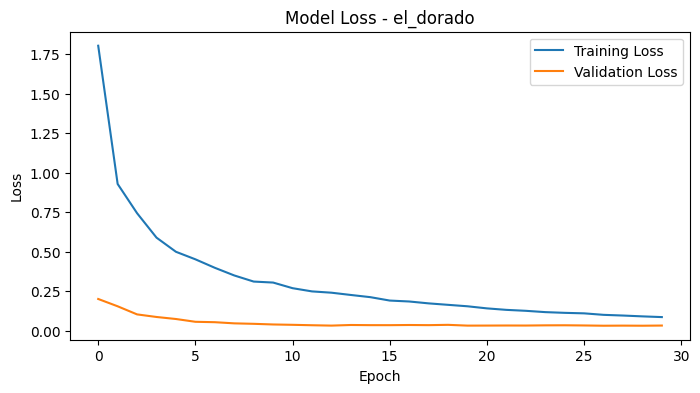

Training history plot saved to training_history_el_dorado.png
Loaded best model based on validation loss
Model saved to kingdom_weather_model_el_dorado.keras
Generating predictions for El Dorado from (9, 1, 1) to (9, 5, 31)...
Using last date for El Dorado: (8, 12, 31)
Starting recursive forecast for El Dorado, need 151 days
Found 2467 records for El Dorado
Generated 151 predictions for El Dorado
Received 151 predictions for El Dorado
Saved predictions to predictions_el_dorado.csv

=== Processing kingdom: Elysium ===
Scaling features for Elysium...
Creating training sequences for Elysium...
Created 300 sequence-target pairs
Training new model for Elysium...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 160)                 │         135,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 160)                 │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 8, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 8, 160)              │         205,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 160)              │             640 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 160)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 8, 80)               │          77,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 80)               │             320 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 80)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 8, 5)                │             405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 420,245 (1.60 MB)

 Trainable params: 419,445 (1.60 MB)

 Non-trainable params: 800 (3.12 KB)

Training with 240 sequences, validating with 60 sequences
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 2.0361
Epoch 1: val_loss improved from inf to 0.18395, saving model to kingdom_weather_model_elysium_best.keras

Epoch 1: saving model to kingdom_weather_model_elysium.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 316ms/step - loss: 1.9980 - val_loss: 0.1840
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 0.9792
Epoch 2: val_loss improved from 0.18395 to 0.14947, saving model to kingdom_weather_model_elysium_best.keras

Epoch 2: saving model to kingdom_weather_model_elysium.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - loss: 0.9712 - val_loss: 0.1495
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.7225
Epoch 3: val_loss improved from 0.14947 to 0.11196, saving model to kingdom_weather_model_elysium_best.keras

Epoch 3: saving model to kingdom_weather_model_elysium.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 0.7189 - val_loss: 0.1120
Epoch 4/30
8/8 ━━━

KeyboardInterrupt: 

In [39]:

# NEW: Process each kingdom individually
all_kingdom_predictions = {}
combined_predictions = []

for kingdom in kingdoms:
    print(f"\n=== Processing kingdom: {kingdom} ===")

    # Filter data for this kingdom only
    kingdom_data = data[data['kingdom'] == kingdom].copy()
    if len(kingdom_data) == 0:
        print(f"No data for kingdom {kingdom}, skipping")
        continue

    # Scale features for this kingdom's data
    print(f"Scaling features for {kingdom}...")
    scaled_kingdom_data, kingdom_scalers = scale_features(kingdom_data, available_input_features)

    # Create training sequences for this kingdom
    print(f"Creating training sequences for {kingdom}...")
    X_train, y_train = create_sequences(
        scaled_kingdom_data, available_input_features, OUTPUT_FEATURES, SEQ_LENGTH, PRED_LENGTH
    )

    if X_train.size == 0 or y_train.size == 0:
        print(f"No training sequences could be created for {kingdom}, skipping")
        continue

    # Train a kingdom-specific model
    print(f"Training new model for {kingdom}...")
    kingdom_model, _ = train_model(
      X_train, y_train, kingdom_scalers,
      epochs=EPOCHS, batch_size=BATCH_SIZE,
      is_using_gpu=is_using_gpu,
      validate=True,
      kingdom_name=kingdom.lower().replace(" ", "_")
    )

    # Fixed prediction dates
    start_date = (9, 1, 1)  # Year 9, Month 1, Day 1
    end_date = (9, 5, 31)   # Year 9, Month 5, Day 31

    print(f"Generating predictions for {kingdom} from {start_date} to {end_date}...")

    # Calculate number of days to predict
    start_days = date_to_days(start_date)
    end_days = date_to_days(end_date)
    num_days = end_days - start_days + 1

    # Get last training date for initial window
    last_date = (8, 12, 31)  # This should be (8, 12, 31) based on your constant

    print(f"Using last date for {kingdom}: {last_date}")

    # Generate predictions using kingdom-specific model
    kingdom_predictions = recursive_forecast(
        kingdom_model, data, kingdom, last_date, num_days,
        available_input_features, OUTPUT_FEATURES
    )
    print(f"Received {len(kingdom_predictions)} predictions for {kingdom}")

    if not kingdom_predictions.empty:
        # Save individual kingdom predictions
        kingdom_file = f"predictions_{kingdom.lower().replace(' ', '_')}.csv"
        kingdom_predictions.to_csv(kingdom_file, index=False)
        print(f"Saved predictions to {kingdom_file}")

        # Store in dictionary and add to combined list
        all_kingdom_predictions[kingdom] = kingdom_predictions
        combined_predictions.append(kingdom_predictions)

    # Clean up to free memory
    tf.keras.backend.clear_session()


In [22]:
# Combine all kingdom predictions
if combined_predictions:
    final_predictions = pd.concat(combined_predictions, ignore_index=True)
    print(f"Combined predictions shape: {final_predictions.shape}")

    if len(final_predictions) > 0:
        # Post-process predictions
        final_predictions = post_process_predictions(final_predictions)

        output_path = (
            "kingdom_weather_predictions_submission.csv"
            if submission_mode else
            "kingdom_weather_predictions_testing.csv"
        )
        final_predictions.to_csv(output_path, index=False)

        # Save final results
        final_predictions.to_csv('results_good_updated.csv', index=False)

        print("Prediction process completed!")
        # return final_predictions, all_kingdom_predictions
else:
    print("No predictions were generated!")

Combined predictions shape: (302, 54)
Prediction process completed!
